In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

branched_model_path = os.path.join(models_base_path, "mnist_continuous_alldigits/2/epoch_90_ckpt.pth")
label_guided_model_path = os.path.join(models_base_path, "mnist_continuous_alldigits_labelguided/1/epoch_30_ckpt.pth")

In [5]:
# Define the branches
classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

input_shape = (1, 28, 28)

In [6]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [7]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/mnist_sample_quality"

os.makedirs(out_path, exist_ok=True)

### Create data loader

In [8]:
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [9]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

def class_to_class_index_tensor(c, classes):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

### Import models

In [10]:
branched_model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat, branched_model_path
).to(DEVICE)

label_guided_model = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat, label_guided_model_path
).to(DEVICE)

### Sample digits

Sampling class: 0


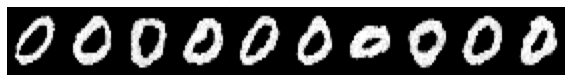

Sampling class: 1


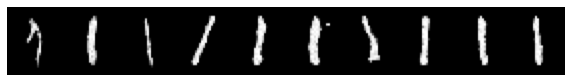

Sampling class: 2


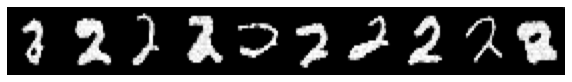

Sampling class: 3


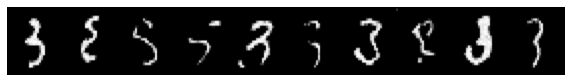

Sampling class: 4


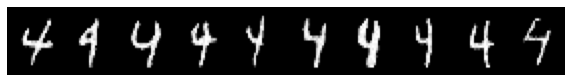

Sampling class: 5


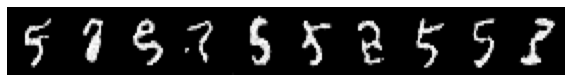

Sampling class: 6


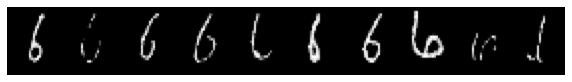

Sampling class: 7


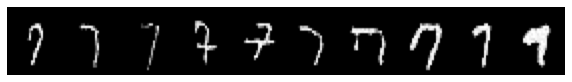

Sampling class: 8


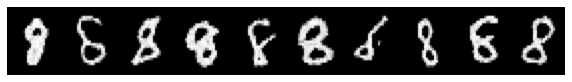

Sampling class: 9


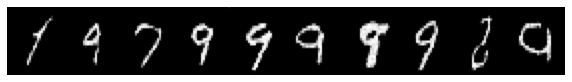

In [11]:
# Sample digits of each class from branched model
branched_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_model, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    branched_samples[class_to_sample] = samples
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)

Sampling class: 0


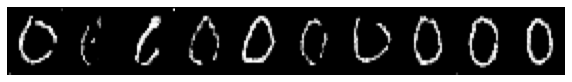

Sampling class: 1


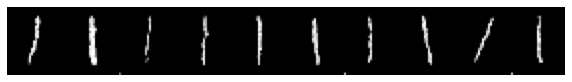

Sampling class: 2


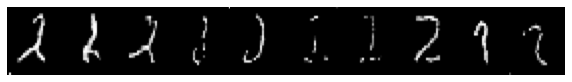

Sampling class: 3


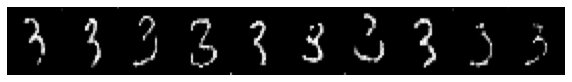

Sampling class: 4


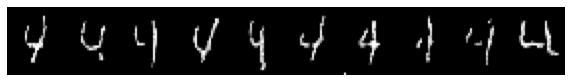

Sampling class: 5


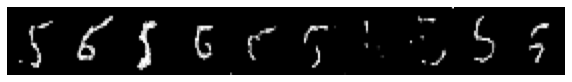

Sampling class: 6


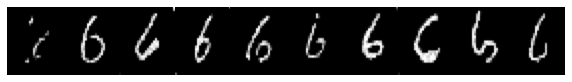

Sampling class: 7


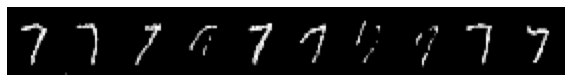

Sampling class: 8


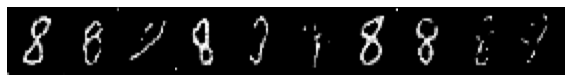

Sampling class: 9


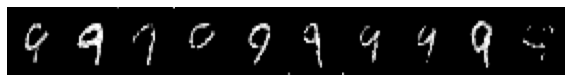

In [12]:
# Sample digits of each class from label-guided model
label_guided_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_model, sde, class_to_sample,
        lambda c: class_to_class_index_tensor(c, classes),
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    label_guided_samples[class_to_sample] = samples
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)

Sampling class: 0


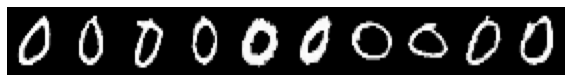

Sampling class: 1


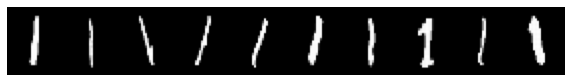

Sampling class: 2


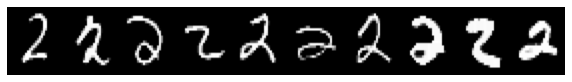

Sampling class: 3


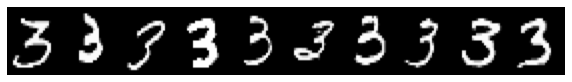

Sampling class: 4


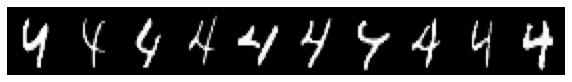

Sampling class: 5


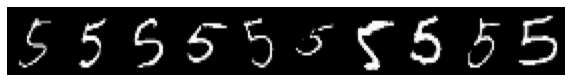

Sampling class: 6


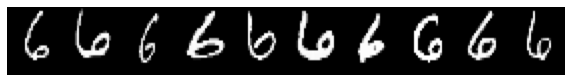

Sampling class: 7


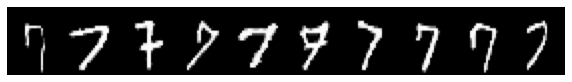

Sampling class: 8


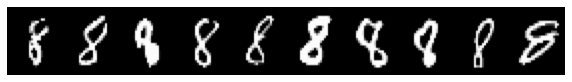

Sampling class: 9


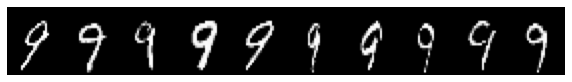

In [13]:
# Sample digits from the original dataset
true_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset.targets == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=1000, replace=False)
    samples = ((dataset.data[sample_inds] / 256 * 2) - 1).cpu().numpy()[:, None]
    true_samples[class_to_sample] = samples
    plot_mnist_digits(samples, grid_size=(10, 1), title=None)

### Compute FID

In [14]:
def compute_fid(samples_1, samples_2):
    """
    Computes the Frechet inception distance between two samples of
    objects. Although the two arrays can have any shape (number of
    dimensions must be at least 2), they must be the same shape and
    distance will be computed by flattening anything after the batch
    dimension.
    Arguments:
        `samples_1`: a B x ... array of B samples
        `samples_2`: a B x ... array of B samples, in the same shape
            as `samples_1`
    Returns a scalar FID score.
    """
    assert samples_1.shape == samples_2.shape
    assert len(samples_1.shape) >= 2
    
    samples_1 = np.reshape(samples_1, (samples_1.shape[0], -1))
    samples_2 = np.reshape(samples_2, (samples_2.shape[0], -1))
    # Shape: B x D
    
    mean_1, cov_1 = np.mean(samples_1, axis=0), np.cov(np.transpose(samples_1))
    mean_2, cov_2 = np.mean(samples_2, axis=0), np.cov(np.transpose(samples_2))
    # Mean shape: D; Covariance matrix shape: D x D
    
    mean_square_norm = np.sum(np.square(mean_1 - mean_2))
    
    # Compute covariance term; because covariance matrices are symmetric,s
    # the order of multiplication here doesn't matter
    cov_mean = scipy.linalg.sqrtm(np.matmul(cov_1, cov_2))
    if np.iscomplexobj(cov_mean):
        # Disscard imaginary part if needed
        cov_mean = np.real(cov_mean)
    cov_term = np.trace(cov_1 + cov_2 - (2 * cov_mean))
    
    return mean_square_norm + cov_term

In [15]:
# Compute FID scores
fid_scores = {}
for class_to_sample in classes:
    print("FID of %d" % class_to_sample)
    branched = branched_samples[class_to_sample]
    label_guided = label_guided_samples[class_to_sample]
    true = true_samples[class_to_sample]
    branched_fid = compute_fid(branched, true)
    label_guided_fid = compute_fid(label_guided, true)
    fid_scores[class_to_sample] = (branched_fid, label_guided_fid)
    print("Branched FID: %.4f" % branched_fid)
    print("Label-guided FID: %.4f" % label_guided_fid)

FID of 0
Branched FID: 96.8546
Label-guided FID: 105.5918
FID of 1
Branched FID: 15.0053
Label-guided FID: 49.4217
FID of 2
Branched FID: 35.3371
Label-guided FID: 111.4119
FID of 3
Branched FID: 63.9389
Label-guided FID: 87.9407
FID of 4
Branched FID: 31.2435
Label-guided FID: 47.4579
FID of 5
Branched FID: 43.4233
Label-guided FID: 72.9024
FID of 6
Branched FID: 56.6390
Label-guided FID: 70.4234
FID of 7
Branched FID: 34.3431
Label-guided FID: 56.0854
FID of 8
Branched FID: 28.4729
Label-guided FID: 85.4064
FID of 9
Branched FID: 23.2763
Label-guided FID: 58.2126


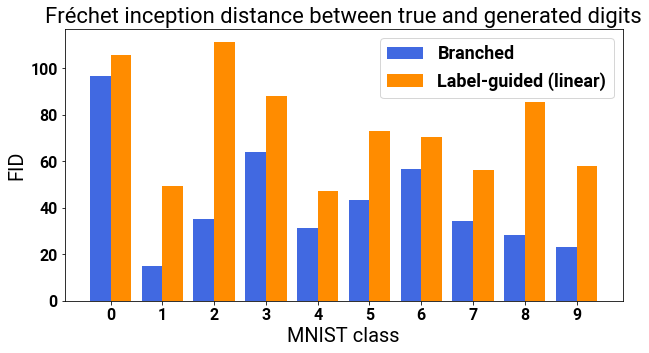

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.4
x = np.arange(len(fid_scores))
ax.bar(
    x, [fid_scores[c][0] for c in classes], bar_width, label="Branched", color="royalblue"
)
ax.bar(
    x + bar_width, [fid_scores[c][1] for c in classes], bar_width, label="Label-guided (linear)", color="darkorange"
)
ax.set_xticks(x + (bar_width / 2), labels=[("%d" % c) for c in classes])
ax.set_xlabel("MNIST class")
ax.set_ylabel("FID")
ax.set_title("Fréchet inception distance between true and generated digits")
ax.legend()
plt.show()
fig.savefig(
    os.path.join(out_path, "mnist_fid.svg"),
    format="svg"
)